In [12]:
import numpy as np 
import pandas as pd 
import sys
import os
import optuna
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score
import matplotlib.pylab as plt
import warnings
from scipy.stats import skew, kurtosis
from datetime import datetime
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=10,20

# Add the grandparent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))
from Utils import FE_helper as FE
from Utils import training_models as TM
from tqdm import tqdm 
import json

# Importing Data

In [13]:
# 2. Load the data
train_df = pd.read_csv('../Original_Data/train_2025.csv') 
test_df = pd.read_csv('../Original_Data/test_2025.csv')

train_df = FE.add_features(train_df)
test_df = FE.add_features(test_df)

test_id = test_df['claim_number']
train_id = train_df['claim_number']
target = train_df['fraud']

ignore_var = ['claim_date.is_weekend', 'claim_date.near_holiday', 'fraud']
train_df = FE.drop_ignored_columns(train_df, ignore_var)
test_df = FE.drop_ignored_columns(test_df, ignore_var)


# Preprocessing Data. Training and Testing Data Needs To Be Fully Numerical Before Proceeding.

In [14]:
class DominantValueFlagger:
    def __init__(self, columns, threshold=0.4):
        self.columns = columns
        self.threshold = threshold
        self.dominant_values_ = {}

    def fit(self, df):
        """
        Identify dominant values for each column based on threshold.
        """
        for col in self.columns:
            value_counts = df[col].value_counts(normalize=True)
            if not value_counts.empty and value_counts.iloc[0] > self.threshold:
                self.dominant_values_[col] = value_counts.index[0]
        return self

    def transform(self, df, separate=False):
        """
        Create binary columns marking where dominant values occur.
        
        Parameters:
            df (pd.DataFrame): Input data
            separate (bool): If True, return only new columns; else return df + new columns
            
        Returns:
            pd.DataFrame
        """
        new_features = pd.DataFrame(index=df.index)

        for col, val in self.dominant_values_.items():
            new_col_name = f"{col}_is_{str(int(val)).replace(' ', '_')}"
            new_features[new_col_name] = (df[col] == val).astype(str)

        return new_features if separate else pd.concat([df.copy(), new_features], axis=1)
flagger = DominantValueFlagger(columns=['vehicle_price', 'age_of_vehicle', 'past_num_of_claims', 'claim_est_payout'], threshold=0.05)


def drop_first_dummy_per_category(df, cat_cols):
    """
    For each original categorical column in `cat_cols`, drop the first one-hot encoded column 
    in the DataFrame that starts with that name + underscore.
    
    Parameters:
        df (pd.DataFrame): One-hot encoded DataFrame
        cat_cols (list): List of original categorical column names (prefixes)
        
    Returns:
        pd.DataFrame: Modified DataFrame with one dummy dropped per group
    """
    df = df.copy()
    for col in cat_cols:
        matching_cols = [c for c in df.columns if c.startswith(f"{col}_")]
        if matching_cols:
            df.drop(matching_cols[0], axis=1, inplace=True)
    return df

In [20]:
updated_train_df = train_df
updated_test_df = test_df

high_dim_cat_cols_to_drop = ['claim_date.day', 'claim_date.dayofweek', 'claim_date.weekofyear', 'claim_date.month']
updated_train_df.drop(columns = high_dim_cat_cols_to_drop, inplace=True, errors='ignore')
updated_test_df.drop(columns = high_dim_cat_cols_to_drop, inplace=True, errors='ignore')

####################################################################################################################
####################################################################################################################
####################################################################################################################
##########################################The Experimental Stuff####################################################
####################################################################################################################
####################################################################################################################
####################################################################################################################
experiment_drops = ['claim_date.quarter']
updated_train_df.drop(columns = experiment_drops, inplace=True, errors='ignore')
updated_test_df.drop(columns = experiment_drops, inplace=True, errors='ignore')

# # Fit on training data
# flagger.fit(updated_train_df)

# # Transform on train or test data
# updated_train_df = flagger.transform(updated_train_df)
# updated_test_df = flagger.transform(updated_test_df)

####################################################################################################################
####################################################################################################################
####################################################################################################################
####################################################################################################################
####################################################################################################################
####################################################################################################################

# Step 1: Fit on training data
onehot, scaler, cat_cols, num_cols = FE.fit_regular_transformer(updated_train_df, '_count')

# Step 2: Transform training set itself
X_train_regular = FE.transform_regular_set(updated_train_df, onehot, scaler, cat_cols, num_cols)

# Step 3: Transform test set (call the same function on test_df)
X_test_regular = FE.transform_regular_set(updated_test_df, onehot, scaler, cat_cols, num_cols)


####################################################################################################################
############################################More Experiment Stuff###################################################
####################################################################################################################
X_train_regular = drop_first_dummy_per_category(X_train_regular, cat_cols)
X_test_regular = drop_first_dummy_per_category(X_test_regular, cat_cols)


# Model Selection

In [21]:
models_list = ['lgb', 'xgb', 'cat', 'hgb', 'ridge']

##########################################################################
##########################################################################
#################### CHANGE THIS NUMBER TO SWAP MODEL ####################
##########################################################################
##########################################################################
model_name= models_list[4] 
output_dir = f'../Records/{model_name}_temp'

train_model_fn = getattr(TM, f"train_{model_name}", None)
params_trial_fn= getattr(TM, f"sample_{model_name}_hyperparams", None)
predict_fn = getattr(TM, f"predict_{model_name}", None)

# Hyper Parameter Tuning For the Chosen Model

In [22]:
pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(lambda trial: TM.objective_single_model(trial=trial, 
                                       full_train_df=X_train_regular, 
                                       target=target, 
                                       train_model_fn= train_model_fn, 
                                       params_trial_fn = params_trial_fn, 
                                       kfoldcv= 5),
                n_trials=10)

best_threshold = study.best_trial.user_attrs['cv_results'].mean(axis = 0)['threshold']
best_params = study.best_params

[I 2025-05-13 14:54:15,016] A new study created in memory with name: no-name-719672fc-0764-48b3-9fb0-24a1403f817c
[I 2025-05-13 14:54:16,899] Trial 0 finished with value: 0.3786300217427136 and parameters: {'C': 0.5182302784139194}. Best is trial 0 with value: 0.3786300217427136.
[I 2025-05-13 14:54:18,787] Trial 1 finished with value: 0.3744992602612861 and parameters: {'C': 0.8235339570111215}. Best is trial 0 with value: 0.3786300217427136.
[I 2025-05-13 14:54:20,683] Trial 2 finished with value: 0.37327492672395535 and parameters: {'C': 6.4990834795940255}. Best is trial 0 with value: 0.3786300217427136.
[I 2025-05-13 14:54:22,576] Trial 3 finished with value: 0.37373122913173906 and parameters: {'C': 1.1658005436798538}. Best is trial 0 with value: 0.3786300217427136.
[I 2025-05-13 14:54:24,486] Trial 4 finished with value: 0.3778167579440025 and parameters: {'C': 6.988409334538613}. Best is trial 0 with value: 0.3786300217427136.
[I 2025-05-13 14:54:26,404] Trial 5 finished with 

# Test Set Prediction Using K-Fold CV

In [23]:
cv_result, avg_probs, models_list = TM.run_cv_evaluation_single_model(X=X_train_regular, 
                                  y=target, 
                                  params=best_params, 
                                  train_model_fn=train_model_fn, 
                                  kfoldcv=20,
                                  test_df=X_test_regular,
                                  predict_fn=predict_fn,
                                  seed=42)

# Save Datasets, Settings, Test Predictions to output_dir

In [24]:
TM.save_settings(train_df=X_train_regular, 
              test_df=X_test_regular, 
              test_id=test_id,
              test_pred=avg_probs, 
              best_params=best_params, 
              threshold_for_f1=best_threshold, 
              output_dir=output_dir, 
              model_name=model_name)
print(f'Output Directory is at {output_dir}')

Output Directory is at ../Records/ridge_temp


# Ridge 'Importance'

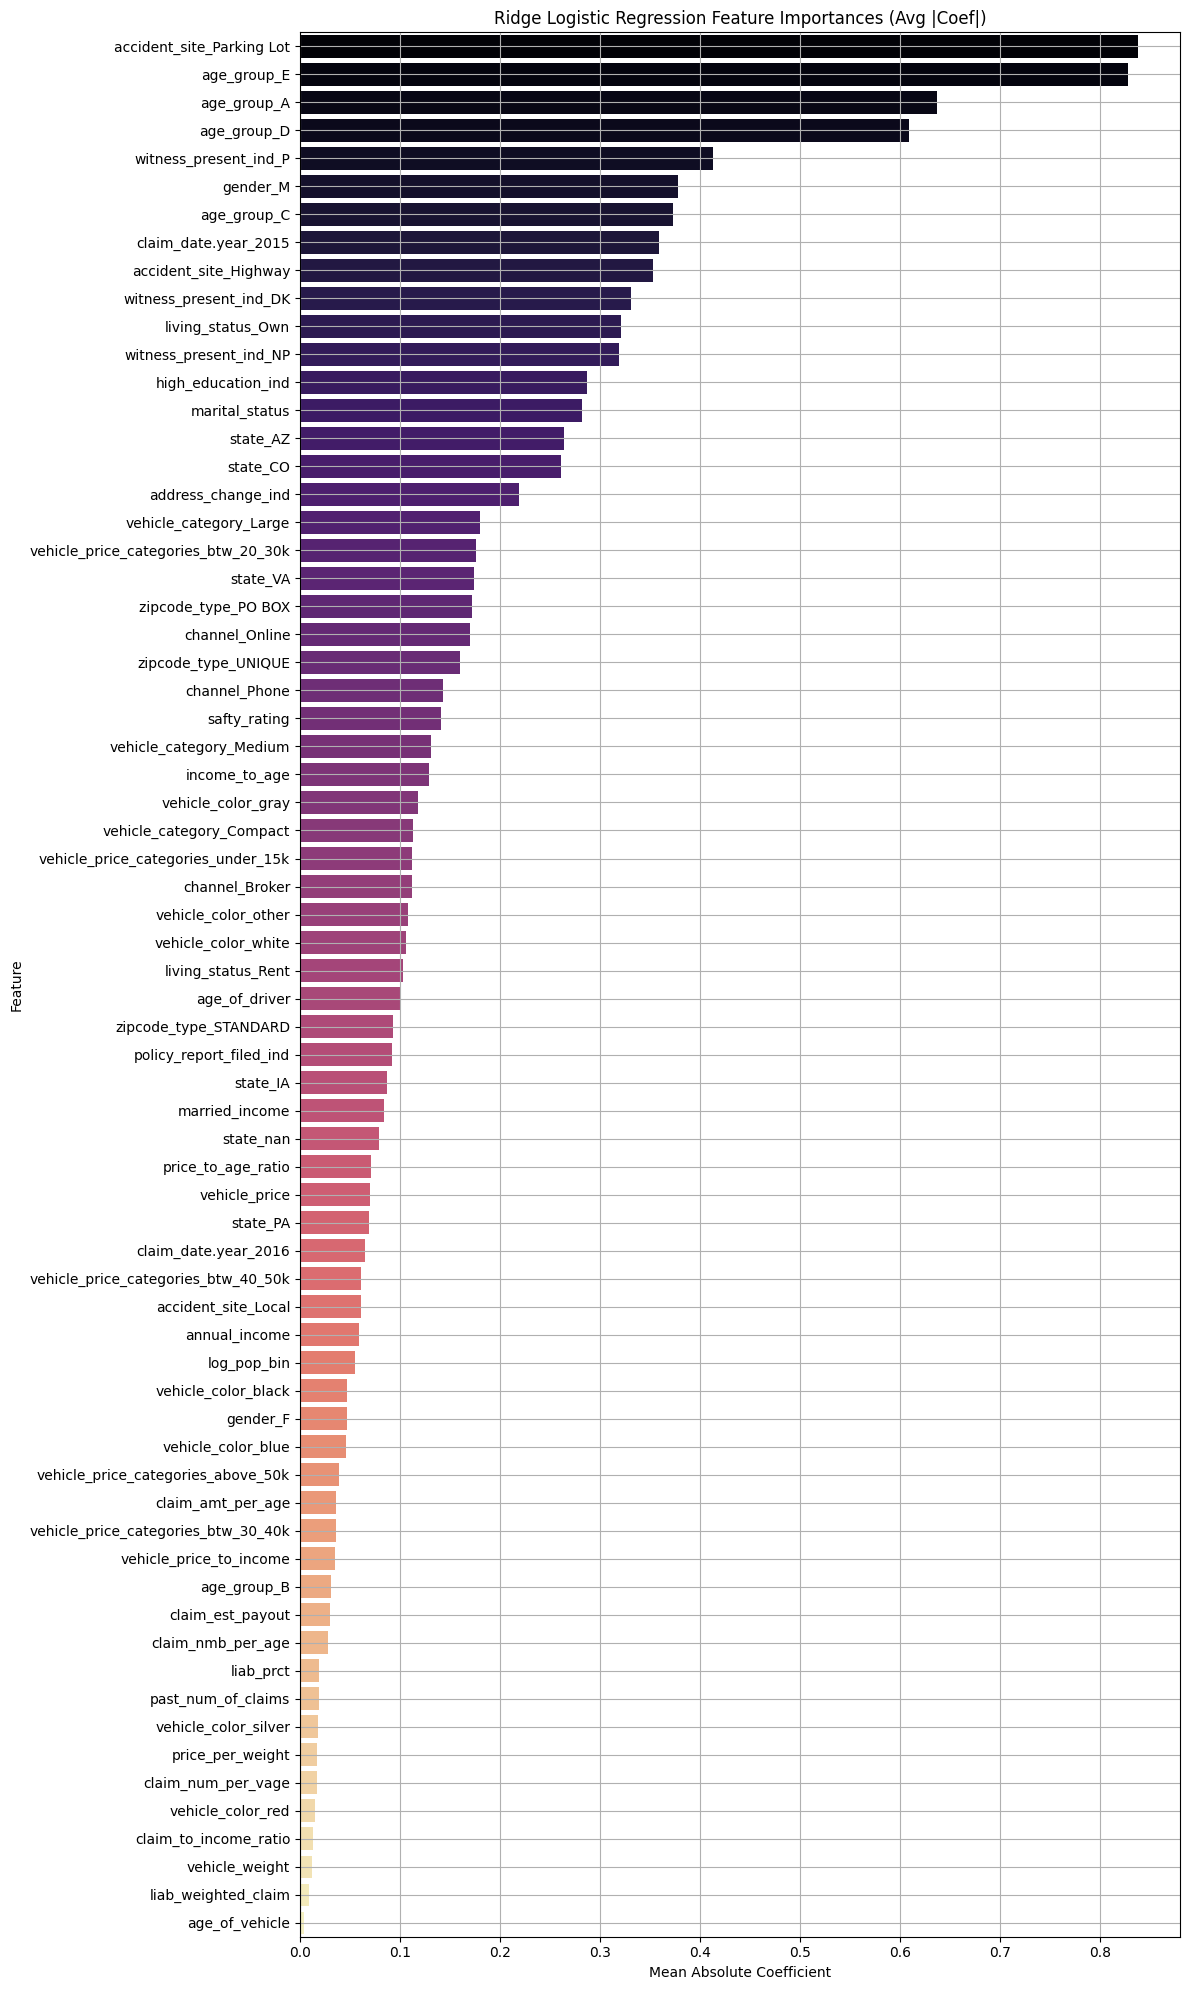

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Extract absolute coefficients from all models
coef_matrix = np.array([np.abs(model.coef_.ravel()) for model in models_list])

# Step 2: Compute average importance across models
mean_abs_coef = coef_matrix.mean(axis=0)

# Step 3: Create DataFrame for plotting
ridge_imp_df = pd.DataFrame({
    'feature': X_train_regular.columns,  # replace with your actual feature list
    'importance': mean_abs_coef
}).sort_values(by='importance', ascending=False)

# Step 4: Plot
plt.figure(figsize=(12, 20))
sns.barplot(data=ridge_imp_df, x='importance', y='feature', palette='magma')
plt.title("Ridge Logistic Regression Feature Importances (Avg |Coef|)")
plt.xlabel("Mean Absolute Coefficient")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()


# CatBoost Importance

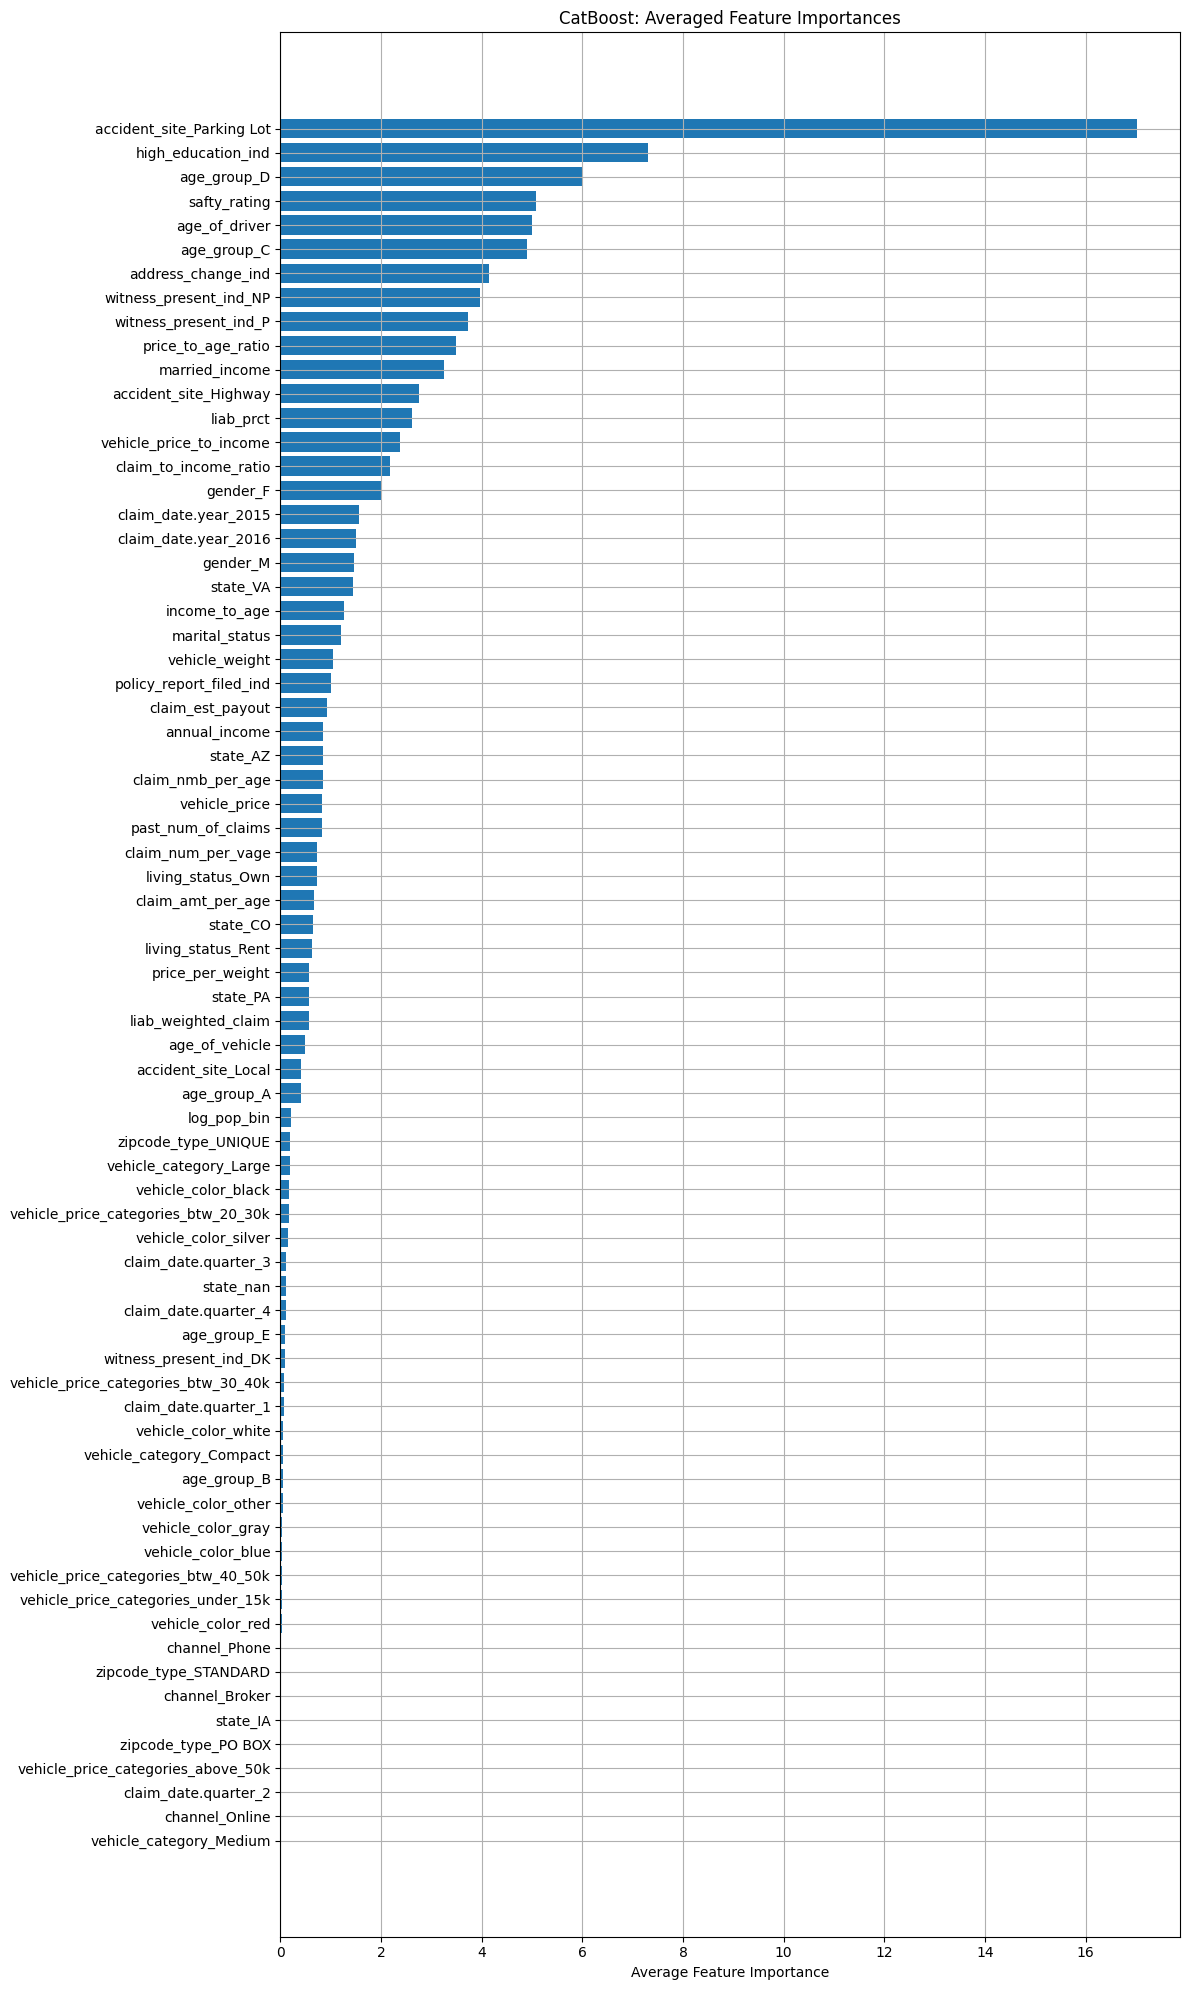

In [79]:
# Step 1: Extract feature importances from each model
importances = [model.get_feature_importance() for model in models_list]

# Step 2: Convert to NumPy array for averaging
importances = np.array(importances)  # shape: (n_models, n_features)

# Step 3: Average across models
mean_importance = np.mean(importances, axis=0)

# Step 4: Get feature names from any model (they should all be the same)
feature_names = models_list[0].feature_names_

# Step 5: Create a DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_importance
}).sort_values(by='importance', ascending=False)

# Step 6: Plot
plt.figure(figsize=(12, 20))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel("Average Feature Importance")
plt.title("CatBoost: Averaged Feature Importances")
plt.gca().invert_yaxis()  # So top features are at the top
plt.tight_layout()
plt.grid(True)
plt.show()

In [121]:
state_features = importance_df[importance_df['feature'].str.startswith('state')]
state_FR = pd.DataFrame(X_train_regular[importance_df[importance_df['feature'].str.startswith('state')]['feature'].to_list()].mean(axis = 0)).reset_index()
state_FR.columns = ['feature', 'FR']
state_FR_imp = pd.merge(state_features, state_FR, on='feature')

<Axes: xlabel='importance_x', ylabel='importance_y'>

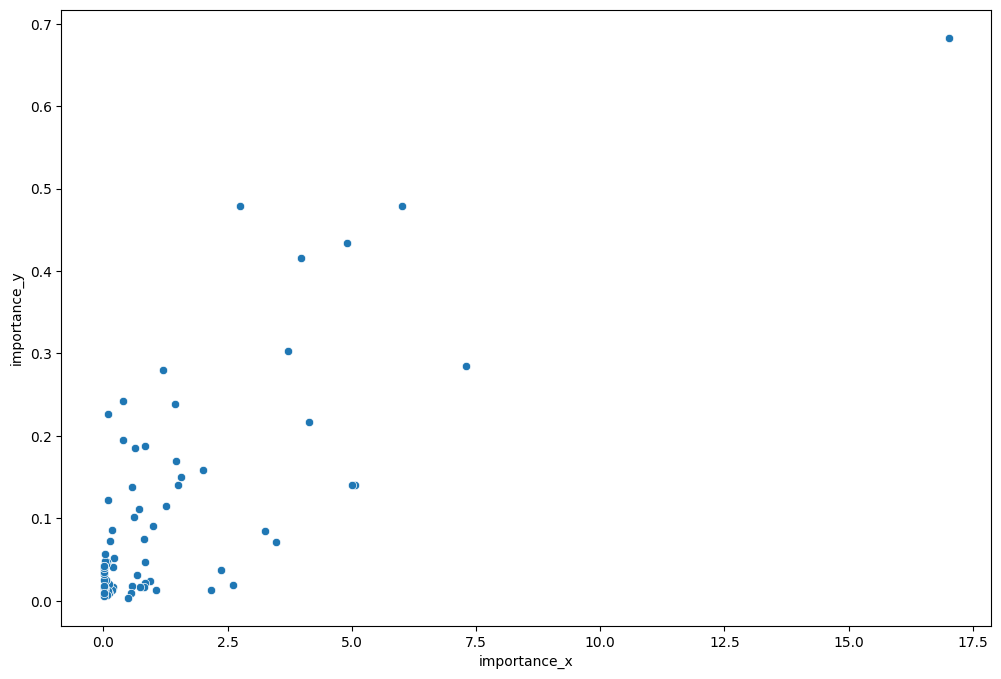

In [141]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'importance_x', y = 'importance_y', data = pd.merge(importance_df, ridge_imp_df, on = 'feature'))

In [143]:
feature_2_models = pd.merge(importance_df, ridge_imp_df, on = 'feature')
feature_2_models

,feature,importance_x,importance_y
0,accident_site_Parking Lot,17.024357,0.683120
1,high_education_ind,7.300944,0.284501
2,age_group_D,6.019693,0.479080
3,safty_rating,5.072050,0.140431
4,age_of_driver,5.008129,0.139908
...,...,...,...
67,zipcode_type_PO BOX,0.016475,0.034995
68,vehicle_price_categories_above_50k,0.014942,0.039734
69,claim_date.quarter_2,0.011608,0.017789
70,channel_Online,0.010159,0.041696


In [154]:
x = 15  # percentage threshold
q = x / 100  # convert to quantile

# Compute quantile cutoffs
cat_thresh = feature_2_models['importance_y'].quantile(q)
ridge_thresh = feature_2_models['importance_x'].quantile(q)

# Filter features that fall below both thresholds
low_importance_features = feature_2_models[
    (feature_2_models['importance_y'] <= cat_thresh) &
    (feature_2_models['importance_x'] <= ridge_thresh)
]

low_importance_features


,feature,importance_x,importance_y
63,channel_Phone,0.020228,0.005250
71,vehicle_category_Medium,0.007858,0.008694
